In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, confusion_matrix, classification_report
import seaborn as sns


# Load and Preprocess Data 

In [2]:
df = pd.read_csv('balanced_dataset.csv')

# Modify labels: 0 -> 1, others (1,2,3,4) -> 0
df['label'] = df['label'].apply(lambda x: 0 if x == 1 else 1)

# Preprocess data
scaler = MinMaxScaler()
X = scaler.fit_transform(df.drop(columns=['label']))
y = df['label'].values

# Feature Selection using Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importances = rf.feature_importances_
feature_names = df.drop(columns=['label']).columns

# Select top k features
k = 10
top_features = [feature for feature, importance in sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)[:k]]

# Reduce dataset to selected features
X_selected = df[top_features].values
X_selected = scaler.fit_transform(X_selected)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to PyTorch tensors
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)


# ANFIS Model

In [3]:
class ANFIS(nn.Module):
    def __init__(self, input_dim, num_rules):
        super(ANFIS, self).__init__()
        self.num_rules = num_rules
        
        # Fuzzy Membership Parameters (Gaussian functions) - Ensuring Stability
        self.mu = nn.Parameter(torch.randn(input_dim, num_rules))
        self.sigma = nn.Parameter(torch.randn(input_dim, num_rules).abs() + 1e-6)  # Avoiding zero sigma
        
        # Output Layer
        self.linear = nn.Linear(num_rules, 1)  # Single output for binary classification
    
    def forward(self, x):
        # Gaussian Membership Functions - Adding Stability
        membership = torch.exp(-((x.unsqueeze(2) - self.mu) ** 2) / (2 * self.sigma ** 2 + 1e-6))
        
        # Rule Activation (Product of Memberships)
        rule_activation = torch.prod(membership, dim=1)
        
        # Normalize Rule Activations - Prevent Division by Zero
        sum_activation = torch.sum(rule_activation, dim=1, keepdim=True) + 1e-6  # Avoid division by zero
        rule_strengths = rule_activation / sum_activation
        
        # Weighted Rule Outputs
        output = self.linear(rule_strengths)
        
        return torch.sigmoid(output).squeeze()  # Apply sigmoid for binary classification

# Initialize model
input_dim = X_train.shape[1]
num_rules = 5  # Number of fuzzy rules
model = ANFIS(input_dim, num_rules)


# training

In [8]:
class_weight = torch.tensor([len(y_train[y_train == 0]) / len(y_train[y_train == 1])])
criterion = nn.BCELoss(weight=class_weight)
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Training loop
num_epochs = 1000 # Increase training epochs for better convergence
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)  # Use adjusted loss function
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/1000], Loss: 0.3720
Epoch [20/1000], Loss: 0.3721
Epoch [30/1000], Loss: 0.3721
Epoch [40/1000], Loss: 0.3719
Epoch [50/1000], Loss: 0.3718
Epoch [60/1000], Loss: 0.3718
Epoch [70/1000], Loss: 0.3717
Epoch [80/1000], Loss: 0.3717
Epoch [90/1000], Loss: 0.3716
Epoch [100/1000], Loss: 0.3716
Epoch [110/1000], Loss: 0.3715
Epoch [120/1000], Loss: 0.3715
Epoch [130/1000], Loss: 0.3714
Epoch [140/1000], Loss: 0.3714
Epoch [150/1000], Loss: 0.3713
Epoch [160/1000], Loss: 0.3713
Epoch [170/1000], Loss: 0.3712
Epoch [180/1000], Loss: 0.3712
Epoch [190/1000], Loss: 0.3711
Epoch [200/1000], Loss: 0.3710
Epoch [210/1000], Loss: 0.3710
Epoch [220/1000], Loss: 0.3709
Epoch [230/1000], Loss: 0.3708
Epoch [240/1000], Loss: 0.3708
Epoch [250/1000], Loss: 0.3707
Epoch [260/1000], Loss: 0.3706
Epoch [270/1000], Loss: 0.3706
Epoch [280/1000], Loss: 0.3705
Epoch [290/1000], Loss: 0.3704
Epoch [300/1000], Loss: 0.3704
Epoch [310/1000], Loss: 0.3703
Epoch [320/1000], Loss: 0.3702
Epoch [330/1000],

Test Loss: 0.4191
Precision: 0.8673


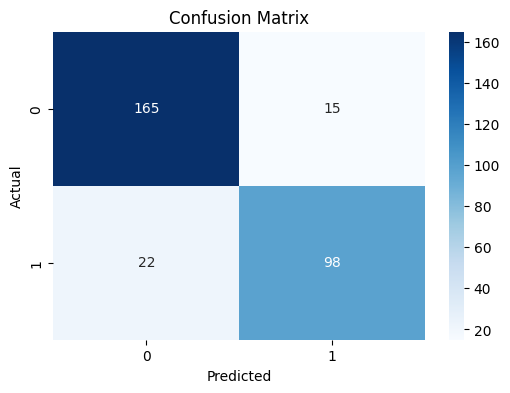

Confusion Matrix:
[[165  15]
 [ 22  98]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90       180
         1.0       0.87      0.82      0.84       120

    accuracy                           0.88       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.88      0.88      0.88       300



In [9]:
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# Convert predictions to binary labels
y_pred_class = (y_pred > 0.5).int().numpy()
y_test_numpy = y_test.numpy()

# Calculate precision
precision = precision_score(y_test_numpy, y_pred_class, average='binary', zero_division=1)
print(f'Precision: {precision:.4f}')

conf_matrix = confusion_matrix(y_test_numpy, y_pred_class)
# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
# Generate confusion matrix

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test_numpy, y_pred_class, zero_division=1))

# Testing

In [290]:
def test_model(sample_input, true_labels=None):
    """
    Function to test the trained ANFIS model on new inputs and compute accuracy.

    Args:
        sample_input (numpy array or torch tensor): Feature data to classify.
        true_labels (numpy array or torch tensor, optional): True labels for accuracy calculation.

    Returns:
        dict: Dictionary containing probabilities, predictions, confidence, and accuracy.
    """
    # Convert input to tensor if it's a NumPy array
    if isinstance(sample_input, np.ndarray):
        sample_input = torch.tensor(sample_input, dtype=torch.float32)

    # Ensure input is 2D (batch format)
    if sample_input.dim() == 1:
        sample_input = sample_input.unsqueeze(0)

    # Make prediction without tracking gradients
    with torch.no_grad():
        probabilities = model(sample_input)  # Get probability scores

    # Convert probabilities to binary classes
    predicted_classes = (probabilities > 0.5).int().numpy()
    probabilities = probabilities.numpy()

    # Compute confidence scores (how far from 0.5 threshold)
    confidence = np.abs(probabilities - 0.5) * 2  # Range: 0 to 1

    # Compute accuracy if true labels are provided
    accuracy = None
    if true_labels is not None:
        if isinstance(true_labels, np.ndarray):
            true_labels = torch.tensor(true_labels, dtype=torch.float32)

        correct_predictions = (predicted_classes.flatten() == true_labels.numpy()).sum()
        accuracy = correct_predictions / len(true_labels) * 100  # Convert to percentage

    # Organize results into a dictionary
    results = {
        "probabilities": probabilities.flatten(),
        "predicted_classes": predicted_classes.flatten(),
        "confidence": confidence.flatten(),
        "accuracy": accuracy,  # Shows None if no true labels are given
    }

    return results


test_sample = X_test[7:15]

# Get predictions
predictions = test_model(test_sample, true_labels=y_test[7:15])

# Display results
for i in range(len(test_sample)):
    print(f"Sample {i+1}:")
    print(f"  Probability: {predictions['probabilities'][i]:.4f}")
    print(f"  Predicted Class: {predictions['predicted_classes'][i]}")
    print(f"  Confidence: {predictions['confidence'][i]:.2%}")
    print("-" * 30)
    
print(f"Overall Accuracy: {predictions['accuracy']:.2f}%")



Sample 1:
  Probability: 0.9831
  Predicted Class: 1
  Confidence: 96.62%
------------------------------
Sample 2:
  Probability: 0.8459
  Predicted Class: 1
  Confidence: 69.19%
------------------------------
Sample 3:
  Probability: 0.0010
  Predicted Class: 0
  Confidence: 99.80%
------------------------------
Sample 4:
  Probability: 0.9754
  Predicted Class: 1
  Confidence: 95.08%
------------------------------
Sample 5:
  Probability: 0.0084
  Predicted Class: 0
  Confidence: 98.31%
------------------------------
Sample 6:
  Probability: 0.0283
  Predicted Class: 0
  Confidence: 94.34%
------------------------------
Sample 7:
  Probability: 0.0009
  Predicted Class: 0
  Confidence: 99.83%
------------------------------
Sample 8:
  Probability: 0.9860
  Predicted Class: 1
  Confidence: 97.20%
------------------------------
Overall Accuracy: 100.00%


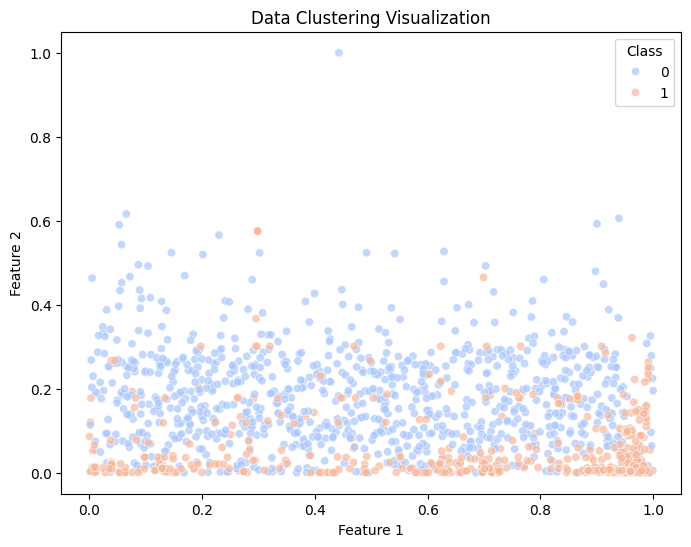

In [279]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='coolwarm', alpha=0.7)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data Clustering Visualization')
plt.legend(title='Class')
plt.show()

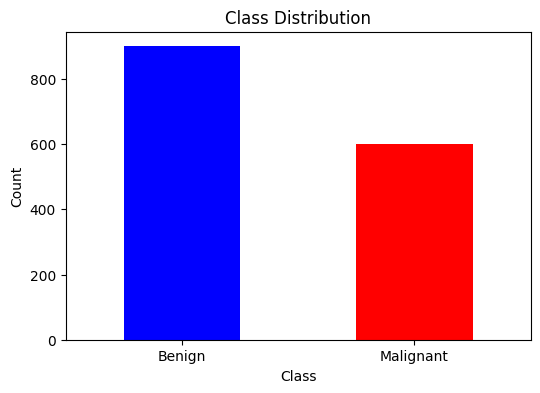

In [256]:
plt.figure(figsize=(6, 4))
class_counts = pd.Series(y).value_counts()
class_counts.plot(kind='bar', color=['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(ticks=[0, 1], labels=['Benign', 'Malignant'], rotation=0)
plt.show()